# THE MOMENTUM EFFECT IN STOCK PRICES


In [ ]:
# Installing necessary libraries
!pip install pandas
!pip install matplotlib
!pip install seaborn

In [ ]:
# Loading the dataset
import pandas as pd
df = pd.read_csv('/momentum_paneldata.csv')
print(df.head())

   PERMNO       date   SICCD TICKER          COMNAM      PRC         VOL  \
0   10107  1/29/2010  7370.0   MSFT  MICROSOFT CORP  28.1800  13640561.0   
1   10107  2/26/2010  7370.0   MSFT  MICROSOFT CORP  28.6700  10779015.0   
2   10107  3/31/2010  7370.0   MSFT  MICROSOFT CORP  29.2875  11181446.0   
3   10107  4/30/2010  7370.0   MSFT  MICROSOFT CORP  30.5350  13259805.0   
4   10107  5/28/2010  7370.0   MSFT  MICROSOFT CORP  25.8000  17259734.0   

      SHROUT  
0  8770461.0  
1  8770461.0  
2  8762000.0  
3  8763839.0  
4  8763839.0  


## ***Now, Creating a Visualization of each and every stock in a pallete...***

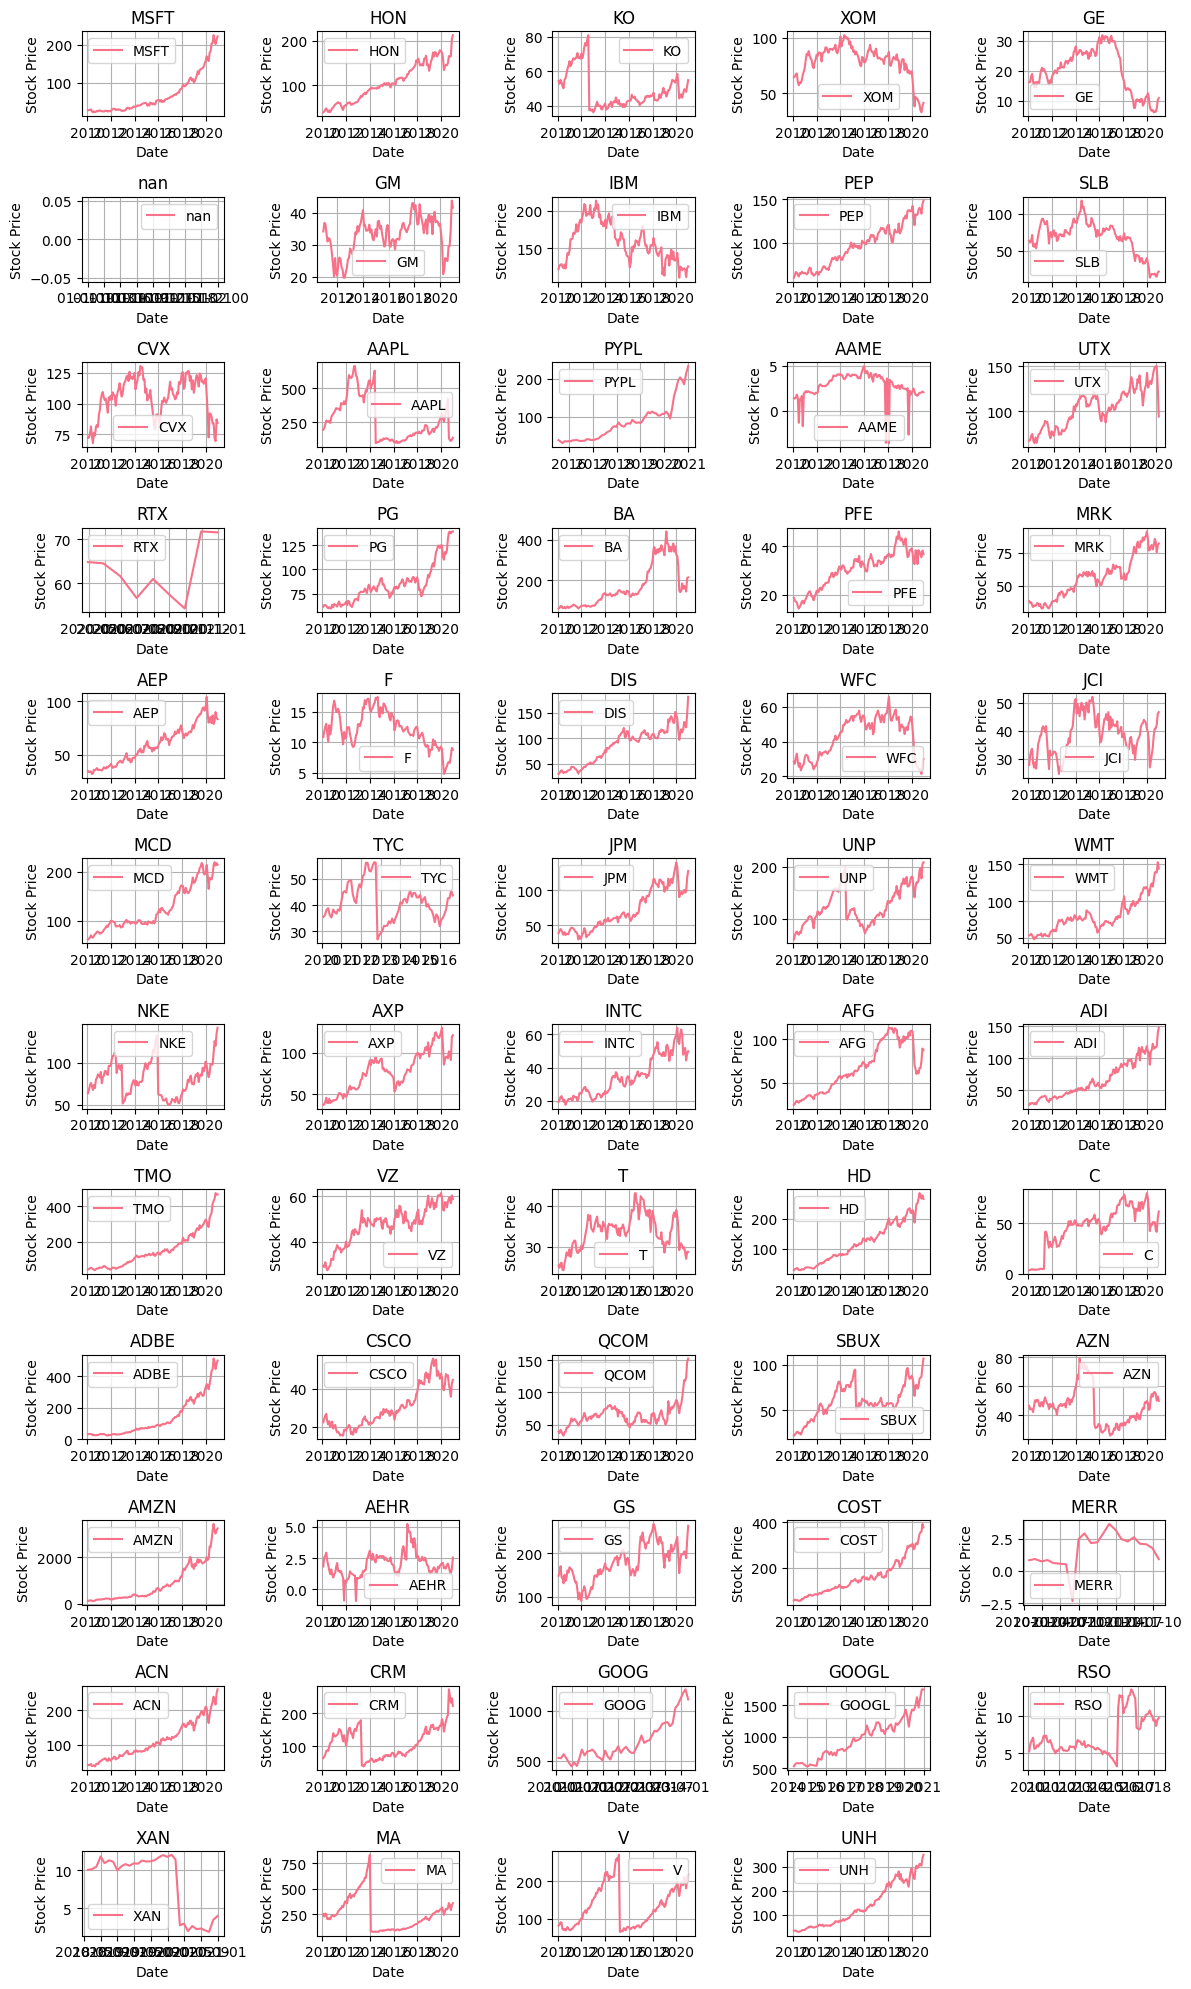

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Create a line plot for each ticker symbol
plt.figure(figsize=(12, 20))
sns.set_palette("husl")  # Set a color palette for the plots

tickers = df['TICKER'].unique()
num_tickers = len(tickers)
rows = num_tickers // 5 + (1 if num_tickers % 5 != 0 else 0)

for i, ticker in enumerate(tickers, 1):
    plt.subplot(rows, 5, i)
    ticker_data = df[df['TICKER'] == ticker]
    plt.plot(ticker_data['date'], ticker_data['PRC'], label=ticker)
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.title(ticker)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


# Momentum Analytics of Stock Prices Using Fama-Macbeth.
*Steps*
1. **Monthly Returns Calculation** -  for Each Stock based on Given Stock Prices.
2. **Portfolio Sorting** - Done to Consturct Portfolios of past winners and Losers.
3. **Fama-MacBeth Regression** - To Finally  Analyze Momentum Effects.

In [ ]:
!pip install statsmodels

In [ ]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [ ]:
# Calculating Monthly Returns
df['Returns'] = df.groupby('TICKER')['PRC'].pct_change()

In [ ]:
#Ensuring Each Ticker has atleast three data points
ticker_counts = df['TICKER'].value_counts()
valid_tickers = ticker_counts[ticker_counts >= 3].index

In [ ]:
#Filtering Dataframe to Include Only Valid Tickers
df = df[df['TICKER'].isin(valid_tickers)]

In [ ]:
print(df.tail())

      PERMNO       date   SICCD TICKER                  COMNAM        PRC  \
7021   92655 2020-08-31  6324.0    UNH  UNITEDHEALTH GROUP INC  312.54999   
7022   92655 2020-09-30  6324.0    UNH  UNITEDHEALTH GROUP INC  311.76999   
7023   92655 2020-10-30  6324.0    UNH  UNITEDHEALTH GROUP INC  305.14001   
7024   92655 2020-11-30  6324.0    UNH  UNITEDHEALTH GROUP INC  336.34000   
7025   92655 2020-12-31  6324.0    UNH  UNITEDHEALTH GROUP INC  350.67999   

           VOL    SHROUT   Returns  
7021  572116.0  950336.0  0.032268  
7022  594917.0  950336.0 -0.002496  
7023  579186.0  950336.0 -0.021266  
7024  744335.0  948821.0  0.102248  
7025  639677.0  948821.0  0.042635  


### In Sorting Portfolio's; It is assumed that;


1.   Top 30% of Best Performers are Winners.
2.   Bottom 30% In Performance are Losers.



In [ ]:
# Sorting Stocks as Winners and Losers Based On Returns...
winners = df.groupby('TICKER')['Returns'].nlargest(int(len(df) * 0.3)).reset_index(level=1, drop=True)
losers = df.groupby('TICKER')['Returns'].nsmallest(int(len(df) * 0.3)).reset_index(level=1, drop=True)

In [ ]:
# Portfolio Creation for Winners and Losers.
#portfolio_winners = df.loc[winners.index]
#portfolio_losers = df.loc[losers.index]

portfolio_winners = df[df.groupby('TICKER')['Returns'].transform(lambda x: x >= x.quantile(0.7))]
portfolio_losers = df[df.groupby('TICKER')['Returns'].transform(lambda x: x <= x.quantile(0.3))]

### Performing Fama-MacBeth Regression on the Portfolios...


In [ ]:
import statsmodels.api as sm

X = sm.add_constant(portfolio_winners['Returns'])
y = portfolio_winners.groupby('TICKER')['Returns'].shift(-1)
model_winners = sm.OLS(y, X, missing='drop').fit()

In [ ]:
X = sm.add_constant(portfolio_losers['Returns'])
y = portfolio_losers.groupby('TICKER')['Returns'].shift(-1)
model_losers = sm.OLS(y, X, missing='drop').fit()

### *Displaying the Regression Results for Both the Winners and Losers*

In [ ]:
print("Fama-MacBeth Regression Results for Winners:")
print(model_winners.summary())

Fama-MacBeth Regression Results for Winners:
                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.798
Date:                Wed, 19 Jul 2023   Prob (F-statistic):             0.0945
Time:                        13:40:40   Log-Likelihood:                 433.71
No. Observations:                1991   AIC:                            -863.4
Df Residuals:                    1989   BIC:                            -852.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const  

In [ ]:
print("\nFama-MacBeth Regression Results for Losers:")
print(model_losers.summary())


Fama-MacBeth Regression Results for Losers:
                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     312.2
Date:                Wed, 19 Jul 2023   Prob (F-statistic):           5.11e-65
Time:                        13:41:07   Log-Likelihood:                 835.19
No. Observations:                1991   AIC:                            -1666.
Df Residuals:                    1989   BIC:                            -1655.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const  